# Ground generation
We generate new maps with different bumps, ramps and texture to train Krock because most of the already existing one were 'too easy' for the robot.

In [11]:
import numpy as np
import cv2 
from utilities.patches import Patch
from interpretability import WebotsRunnablePatch
from opensimplex import OpenSimplex


In [12]:
%matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,7)
%reload_ext autoreload
%autoreload 2


## New custom Patch
We used the [Patches](https://github.com/FrancescoSaverioZuppichini/Master-Thesis/tree/master/core/utilities/patches) API to create a new custom patch that is able to self-generate a new terrain

In [7]:
p_map = Patch((513, 513))

class RandomTerrain(WebotsRunnablePatch):
    def __init__(self, patch_size, feature_size=24, scale=10):
        super().__init__(patch_size)
        self.feature_size = feature_size
        self.scale = scale
        self.simplex = OpenSimplex()
        
    def __call__(self):
        h, w = self.hm.shape[0], self.hm.shape[1]
        for y in range(0, h):
            for x in range(0, w):
                value = self.simplex.noise2d(x / self.feature_size, y / self.feature_size)
                self.hm[x, y] += value / self.scale
        return self
    
    def __iadd__(self, p):
        self.hm += p.hm
        return self


In [8]:
OUT_DIR = './maps/new-train/'

# Utilities
We will use these two utilities function that progressive elevate and reduce a map to increase the noise in each image

In [9]:
def elevate(patch, strenght=3, mode='linear'):
    factors = np.linspace(0, strenght, patch.hm.shape[0])
    if mode == 'pow': factors = factors ** 2
    patch.hm = patch.hm + factors
    
def reduce(patch, factor=3, shuffle=False):
    factors = np.linspace(1, factor, patch.hm.shape[0])
    if shuffle:  np.random.shuffle(factors)
    patch.hm = patch.hm / factors
    return patch

# Texture
We decide to add three different texture to each map. These very noise images are scaled by a big factor to create a random rocky terrain

In [10]:
def get_rocks(shape):
    rocky1 = RandomTerrain(shape, feature_size=5, scale=15)()
    rocky2 = RandomTerrain(shape, feature_size=10, scale=15)()
    rocky3 = RandomTerrain(shape, feature_size=25, scale=15)()

    return [reduce(rocky1, 5).hm.T, reduce(rocky2, 3).hm.T, reduce(rocky3, 3).hm.T]

# Bumps
We will create three different bumps map with an increasing numbers of bumps
# Bumps1

<IPython.core.display.Javascript object>


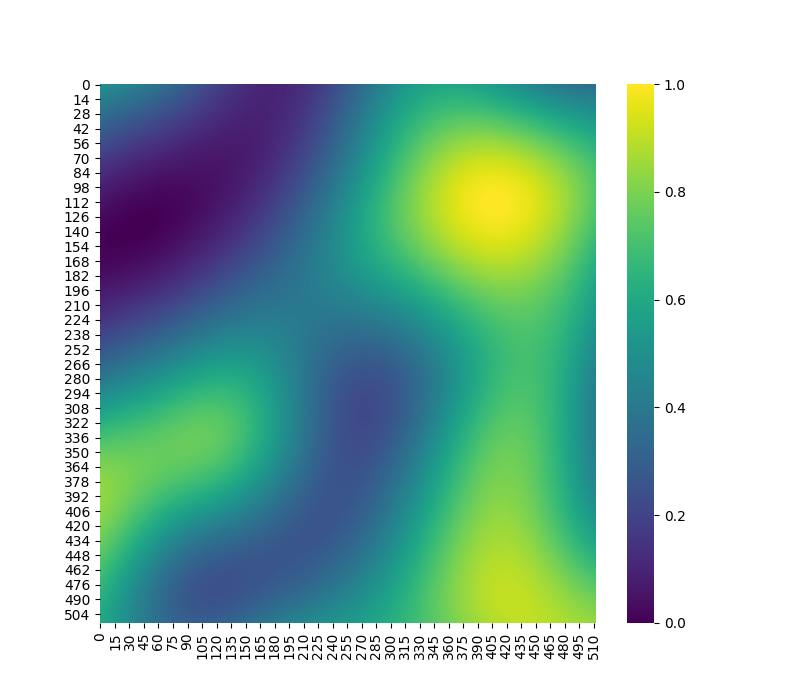

In [72]:
bumps1 = RandomTerrain((513, 513), feature_size=200, scale=1)()
bumps1.hm = bumps1.norm
bumps1.plot2d()

for (j, rock) in enumerate(rocks):
        temp = Patch.from_hm(bumps1.hm + (rock / 2))
        temp.hm = temp.norm
        temp.save(OUT_DIR + '/bumps0-rocks{}.png'.format(j))

<IPython.core.display.Javascript object>


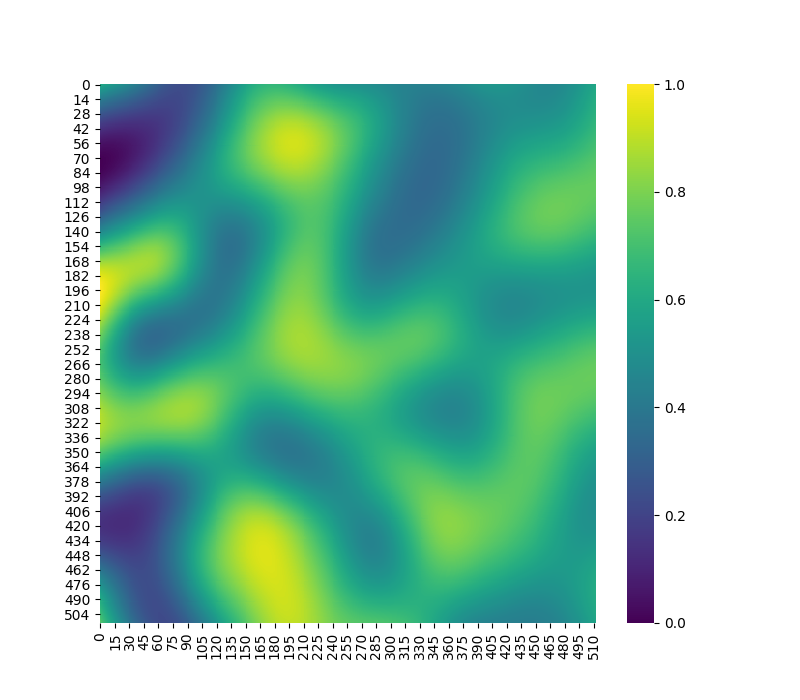

In [11]:
bumps2 = RandomTerrain((513, 513), feature_size=100, scale=1)()
reduce(bumps2, 3)
# bumps2 += rocky3
bumps2.hm = bumps2.norm
_ = bumps2.plot2d()


<IPython.core.display.Javascript object>


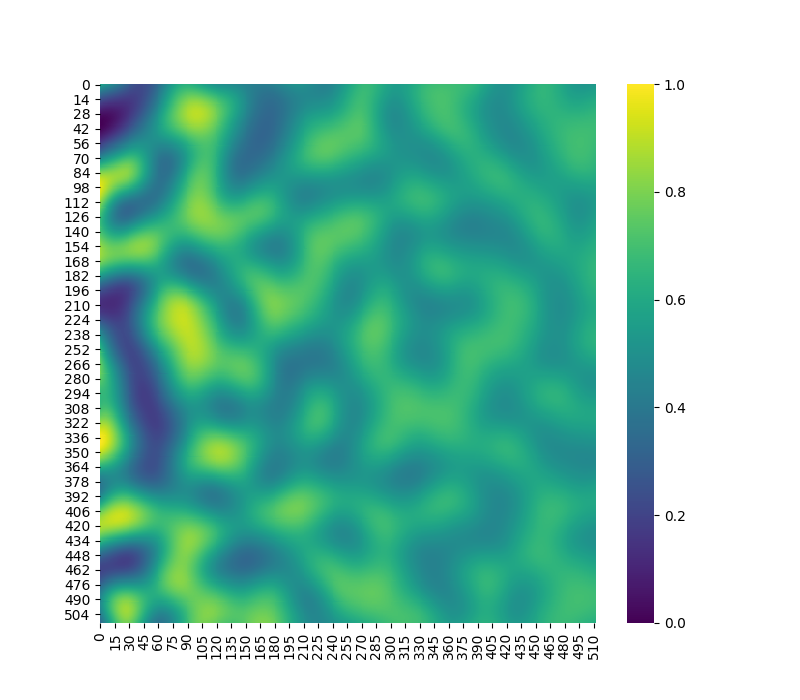

In [12]:
bumps3 = RandomTerrain((513, 513), feature_size=50, scale=1)()
reduce(bumps3, 5)
bumps3.hm = bumps3.norm
_ = bumps3.plot2d()
# bumps3.run_on_simulator(1)


<IPython.core.display.Javascript object>


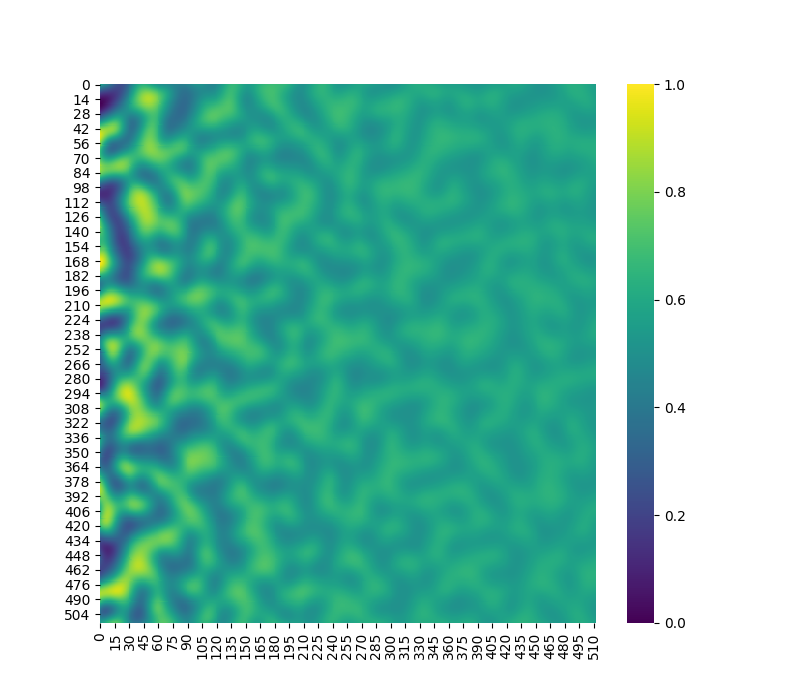

In [13]:
bumps4 = RandomTerrain((513, 513), feature_size=25, scale=2)()
reduce(bumps4, 10)
bumps4.hm = bumps4.norm
_ = bumps4.plot2d()


In [70]:
# store everything
bumps = [bumps1, bumps2, bumps3, bumps4]
from utilities.patches.texture import get_rocks

rocks = get_rocks((513,513))

for (i, bump) in enumerate(bumps):
    bump.save(OUT_DIR + '/bumps{}.png'.format(i, j))
    for (j, rock) in enumerate(rocks):
        temp = Patch.from_hm(bump.hm + rock)
        temp.hm = temp.norm
        temp.save(OUT_DIR + '/bumps{}-rocks{}.png'.format(i, j))

# Ramps

<IPython.core.display.Javascript object>


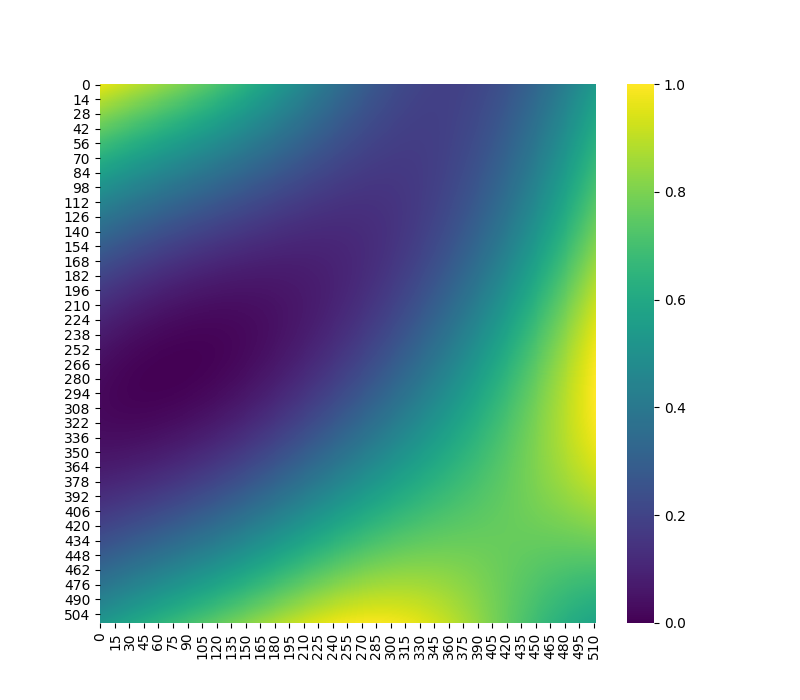

<IPython.core.display.Javascript object>


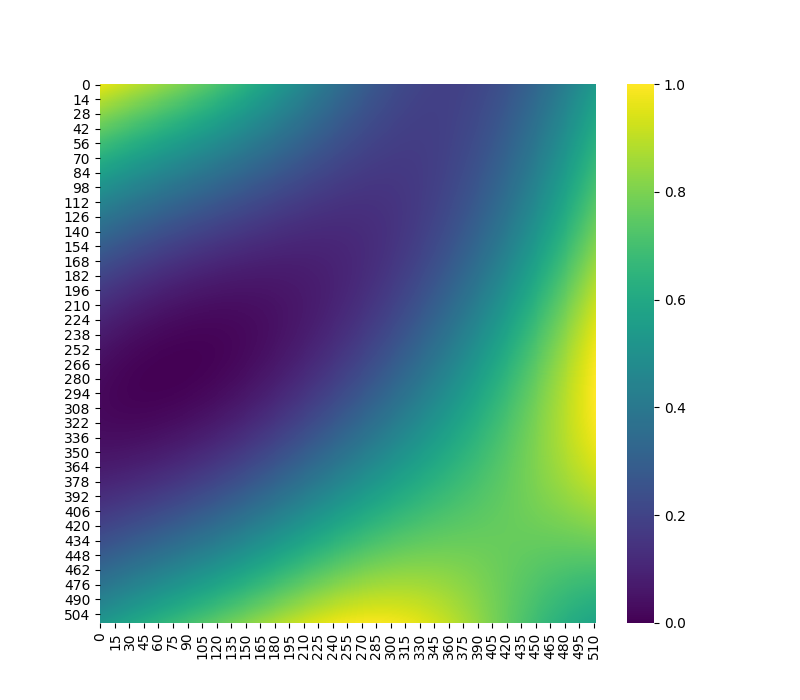

In [15]:
ramps = []
ramps1 = RandomTerrain((513, 513), feature_size=400, scale=1)
ramps1()
ramps1.hm = ramps1.norm
ramps1.plot2d()

for (j, rock) in enumerate(rocks):
        temp = Patch.from_hm(ramps1.hm + (rock / 2))
        temp.hm = temp.norm
        temp.save(OUT_DIR + '/ramp0-rocks{}.png'.format(j))


<IPython.core.display.Javascript object>


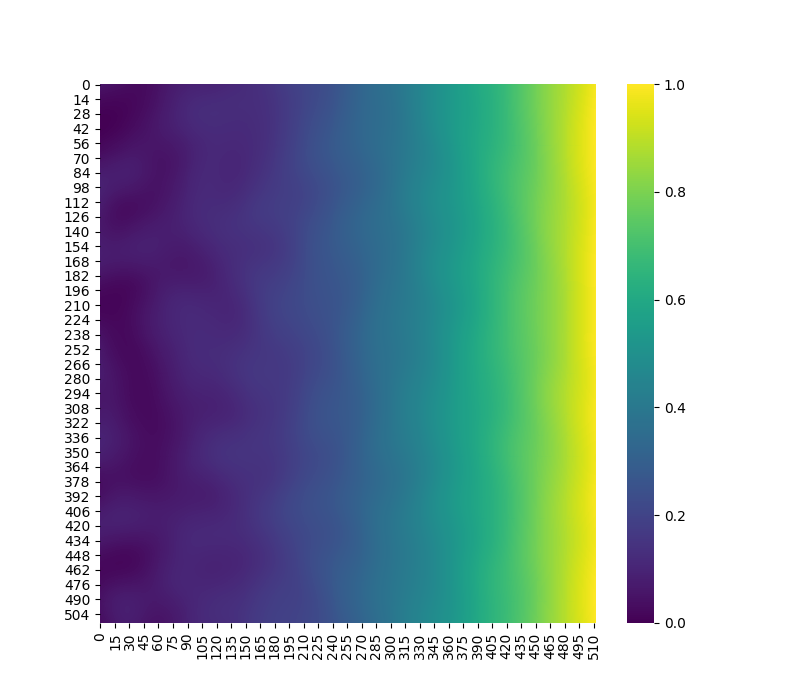

In [17]:
ramps2 = RandomTerrain((513, 513))
# rand()

elevate(ramps2, 2, mode='pow')
ramps2.hm += bumps3.hm * 0.4
ramps2.hm = ramps2.norm
_ = ramps2.plot2d()

# ramps2.hm *= 4
# ramps2.run_on_simulator(20)

ramps.append(ramps2)

<IPython.core.display.Javascript object>


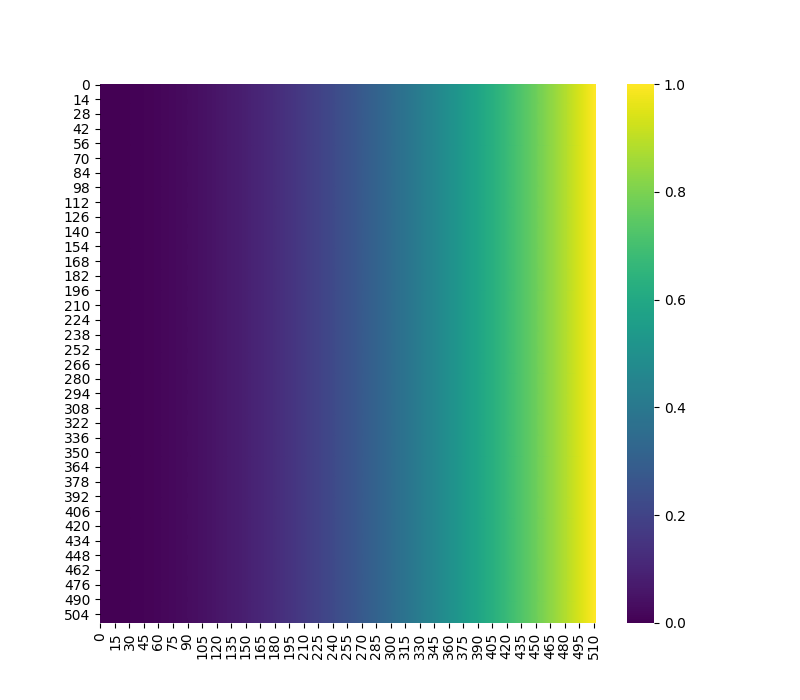

In [18]:
ramps3 = RandomTerrain((513, 513))

elevate(ramps3, 3, mode='pow')
ramps3.hm = ramps3.norm
# ramps3.hm *= 5
_ = ramps3.plot2d()
# ramps3.run_on_simulator(1)

ramps.append(ramps3)

# ramps3.run_on_simulator(20)


In [66]:
?store everything
for (i, ramp) in enumerate(ramps):
    ramp.save(OUT_DIR + '/ramp' + str(i) + '.png')
    for (j, rock) in enumerate(rocks):
        temp = Patch.from_hm(ramp.hm + rock)
    #         bump.hm = bump.norm
        temp.hm = temp.norm
        temp.save(OUT_DIR + '/ramp{}-rocks{}.png'.format(i, j))

## Sullen
We need to rescale sullen

In [18]:
from utilities.postprocessing.handlers.functional import read_image

sullen = read_image('/home/francesco/Documents/Master-Thesis/core/maps/test/sullens_me_cropped_resized_smoothed.png')

sullen = cv2.resize(sullen, (int(sullen.shape[0] * 1.5), int(sullen.shape[1] * 1.5))) # curret is 3cm, we need 2

cv2.imwrite('/home/francesco/Documents/Master-Thesis/core/maps/test/sullens_me_cropped_resized_smoothed_resize.png', sullen)

True

In [16]:
sullen.shape

(769, 769)